In [1]:
"""
Takes TAS Fire History shapefiles, crops to match xarray coordinates of specified netcdf file,
and outputs a an xarray DataArray with recorded fires (x,y,time)
"""

'\nTakes TAS Fire History shapefiles, crops to match xarray coordinates of specified netcdf file,\nand outputs a an xarray DataArray with recorded fires (x,y,time)\n'

In [2]:
import numpy as np
import pandas as pd
import geopandas
import xarray as xr

from rasterio import features
from affine import Affine

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from pylab import rcParams

%matplotlib inline
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_rows', None)
rcParams['figure.figsize'] = (20,8)


In [3]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape, transform = transform,
                                fill=fill, all_touched = True,
                                dtype=float, **kwargs)
    
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))

In [4]:
#open original netcdf Dataset, this is just to make sure that x,y, coordinates match...
data = xr.open_dataset('/g/data/xc0/project/Burn_Mapping/01_LS_Reflectance_and_Indices/Tas2016_Central_Plateau_NBAR_and_Indices.nc')

In [5]:
#define location of Shapefile
df = geopandas.read_file("/home/603/rp1375/Desktop/Link to Ram/Burn Mapping/03 Validation Data/Tas Fire History/fire_history_all_fires_20170907.shp")

#define projection of shapefile 
df.crs = {'init' :'epsg:28355'}
#Convert to same projection as the input netcdf DataArray
df = df.to_crs({'init': 'epsg:3577'})

#format shapefile attributes to datetime64 format
df.IGN_DATE = df.IGN_DATE.astype('datetime64[ns]')

#crop by area and timestamp
df = df[df.IGN_DATE > '2000-01-01']

x_extent = [data.x.min() , data.x.max()]
y_extent = [data.y.min() , data.y.max()]
df = df.cx[ x_extent[0]:x_extent[1] , y_extent[0]:y_extent[1]]

#crop only fires with burned area greater than 8x8 landsat pixels (i.e. 500x500 m2)
df = df[df.SHAPE_AREA > 25*10000]

I am densified (external_values, 7249 elements)


In [6]:
"""
For each unique fire event in the GeoDataFrame 'df', creates a xarray DataArray, applies the appropriate
timestamp, and concatenates to form a 3D (x,y,time) DataArray 
"""

coords = data.drop('time').coords

for date in np.unique(df.IGN_DATE):
    shapes = [(shape,1) for  n, shape in enumerate(df[df.IGN_DATE == date].geometry)]
    
    try:
        new_da = rasterize(shapes , coords)
        new_da = new_da.assign_coords(time = date)
        new_da = new_da.expand_dims('time')
        
        output_array = xr.concat((output_array,new_da), dim='time')
        
    except NameError:
        output_array = rasterize(shapes , coords)
        output_array = output_array.assign_coords(time = date)
        output_array = output_array.expand_dims('time')

output_array = output_array.dropna(dim='time',how='all')


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


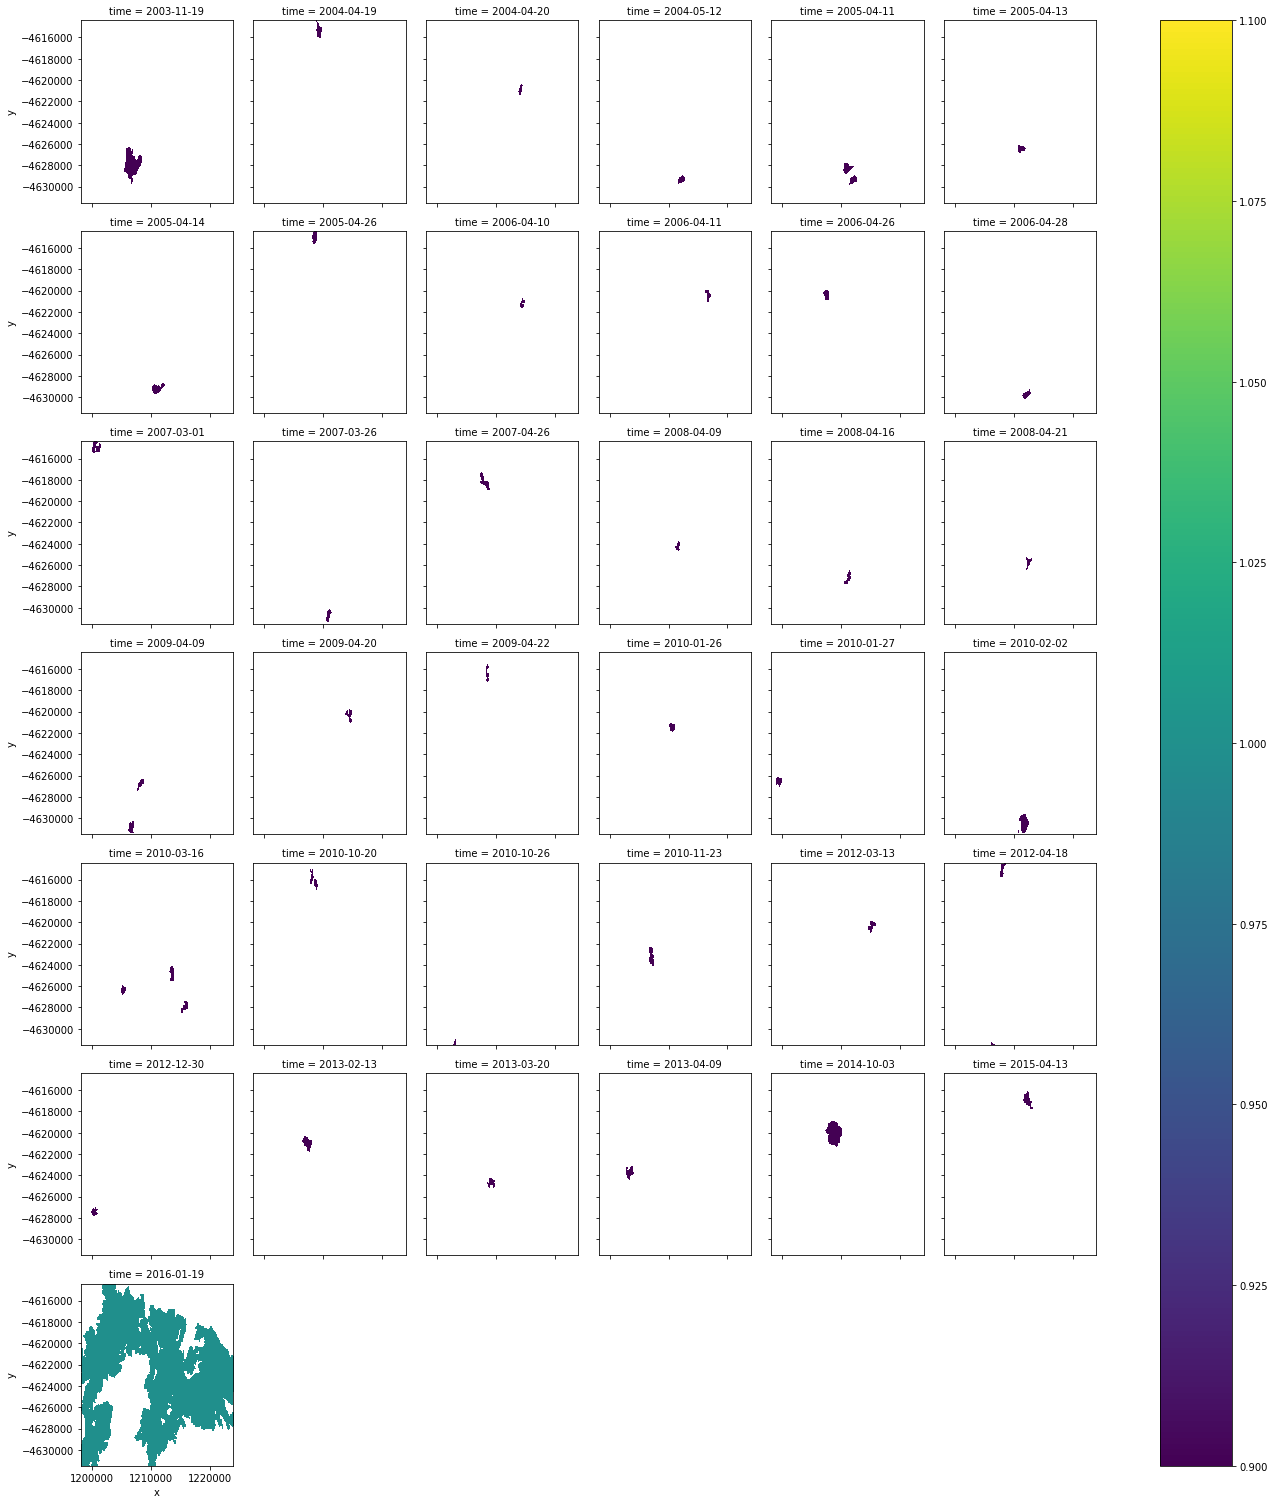

In [7]:
output_array.plot.imshow(col='time',col_wrap=6)